In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

Разметка датасета

In [ ]:
df = pd.read_csv('preprocessed_data.csv')
df.drop(df.columns[0], axis=1, inplace=True)

df[['Обработка названия']] = df[['Обработка названия']].astype(str)
df_cleaned = df.dropna(subset=['Обработка названия'])


texts = df['Обработка названия'].values
categories = df['Категория'].values

texts
categories

array(['Аминокислоты', 'Аминокислоты', 'Аминокислоты', ...,
       'Продукты пчеловодства', 'Продукты пчеловодства',
       'Продукты пчеловодства'], dtype=object)

In [3]:
label_encoder = LabelEncoder()
categories = label_encoder.fit_transform(categories)


X_train, X_temp, y_train, y_temp = train_test_split(texts, categories, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Токенизация и подготовка данных

In [ ]:
# Создаем словарь (vocab) из текста
def build_vocab(texts):
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for text in texts:
        for token in text.split():  # Разделение по пробелам
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

vocab = build_vocab(X_train)
vocab_size = len(vocab)

# Преобразуем текст в индексы
def text_to_sequence(text, vocab, max_len=30):
    tokens = text.split()
    seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(seq) < max_len:
        seq += [vocab['<PAD>']] * (max_len - len(seq))
    return seq[:max_len]

max_len = 30  # Максимальная длина текстов
X_train_seq = np.array([text_to_sequence(text, vocab, max_len) for text in X_train])
X_test_seq = np.array([text_to_sequence(text, vocab, max_len) for text in X_test])

Создаем Dataset и DataLoader

In [ ]:
class DrugDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = DrugDataset(X_train_seq, y_train)
test_dataset = DrugDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Определяем модель

In [ ]:
import torch.nn as nn

class DrugClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob):
        super(DrugClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        logits = self.fc(hidden[-1])  # Последнее скрытое состояние
        return logits

# Гиперпараметры модели
embedding_dim = 50
hidden_dim = 128
output_dim = len(label_encoder.classes_)
dropout_prob = 0.3

# Инициализация модели
model = DrugClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

\\?\C:\Users\alexv\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


DrugClassifier(
  (embedding): Embedding(4343, 50)
  (lstm): LSTM(50, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=14, bias=True)
)

Тренируем модель

In [12]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter(log_dir='runs/drug_classifier')

def train_model(model, train_loader, val_loader, epochs=100):
    best_val_loss = float('inf')
    best_train_acc = 0.0
    best_model_state = None
    patience_counter = 0
    
    # Сохранение метрик для графиков
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        writer.add_scalar('Loss/train', train_losses[-1], epoch)
        writer.add_scalar('Accuracy/train', train_accuracies[-1], epoch)
        
        # Сохраняем модель с самой высокой точностью на тренировочных данных
        if train_accuracy > best_train_acc:
            best_train_acc = train_accuracy
            best_model_state = model.state_dict()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = 0
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()
        
        val_accuracy = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        writer.add_scalar('Loss/val', val_losses[-1], epoch)
        writer.add_scalar('Accuracy/val', val_accuracies[-1], epoch)
        
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_losses[-1]:.4f}, "
            f"Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
            f"Val Acc: {val_accuracies[-1]:.4f}"
        )
    
    # Возвращаем лучшую модель (по точности на тренировочных данных) и метрики
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Обучение модели
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, test_loader, epochs=200
)

Epoch 1: Train Loss: 2.3722, Train Acc: 0.1985, Val Loss: 2.3711, Val Acc: 0.2008
Epoch 2: Train Loss: 2.3611, Train Acc: 0.2025, Val Loss: 2.3695, Val Acc: 0.2008
Epoch 3: Train Loss: 2.3591, Train Acc: 0.2025, Val Loss: 2.3686, Val Acc: 0.2008
Epoch 4: Train Loss: 2.3593, Train Acc: 0.2025, Val Loss: 2.3671, Val Acc: 0.2008
Epoch 5: Train Loss: 2.3592, Train Acc: 0.2025, Val Loss: 2.3697, Val Acc: 0.2008
Epoch 6: Train Loss: 2.3586, Train Acc: 0.2025, Val Loss: 2.3661, Val Acc: 0.2008
Epoch 7: Train Loss: 2.3596, Train Acc: 0.2025, Val Loss: 2.3667, Val Acc: 0.2008
Epoch 8: Train Loss: 2.3584, Train Acc: 0.2025, Val Loss: 2.3725, Val Acc: 0.2008
Epoch 9: Train Loss: 2.3589, Train Acc: 0.2025, Val Loss: 2.3659, Val Acc: 0.2008
Epoch 10: Train Loss: 2.3589, Train Acc: 0.2025, Val Loss: 2.3675, Val Acc: 0.2008
Epoch 11: Train Loss: 2.3582, Train Acc: 0.2025, Val Loss: 2.3657, Val Acc: 0.2008
Epoch 12: Train Loss: 2.3575, Train Acc: 0.2025, Val Loss: 2.3657, Val Acc: 0.2008
Epoch 13: Tra

Выводим результаты обучения на графике

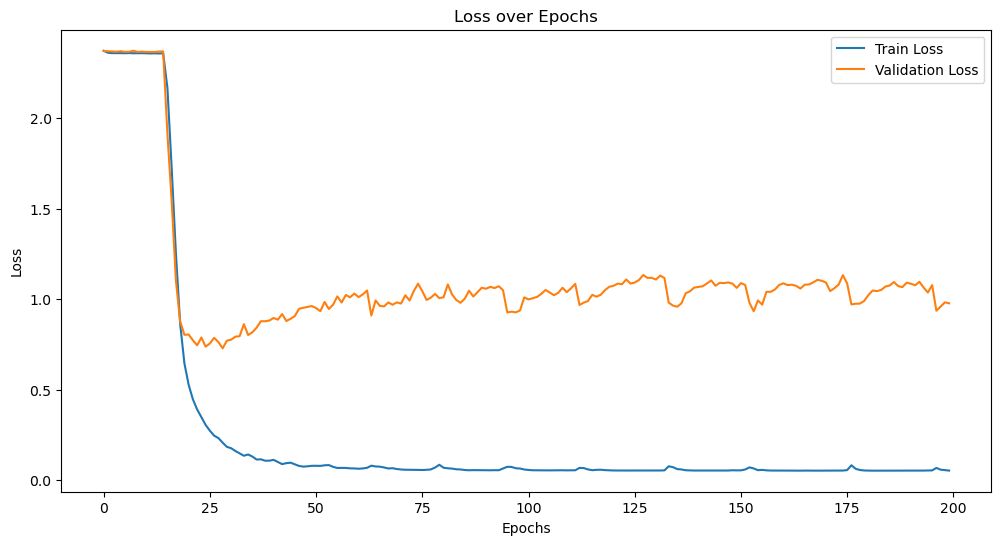

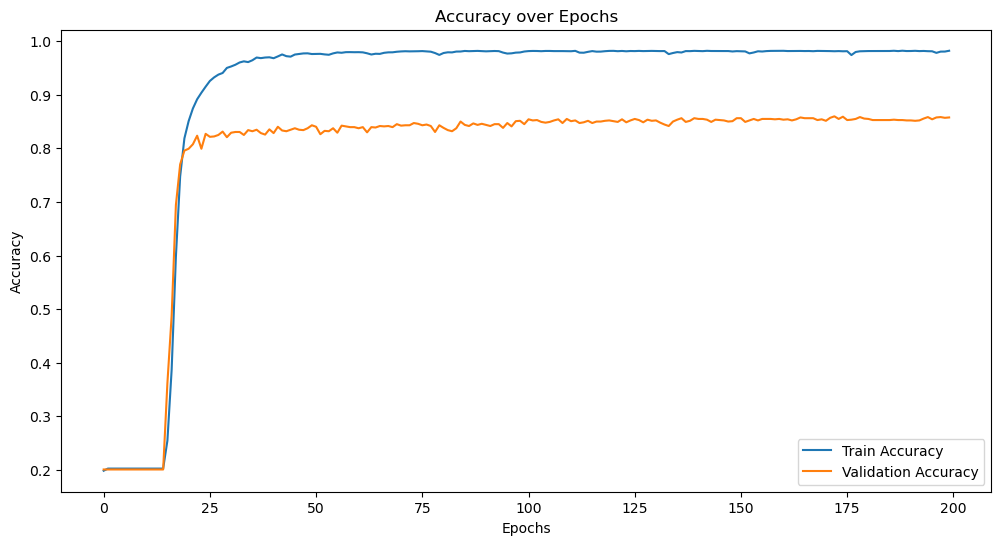

In [14]:
def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    # Построение графиков потерь
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Построение графиков точности
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Построение графиков
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

writer.close()

Визуализация эмбеддингов

In [ ]:
def extract_embeddings(model, data_loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for texts, label in data_loader:
            texts = texts.to(device)
            embedded = model.embedding(texts)
            _, (hidden, _) = model.lstm(embedded)
            embeddings.append(hidden[-1].cpu().numpy())
            labels.append(label.numpy())
    return np.vstack(embeddings), np.hstack(labels)

embeddings, labels = extract_embeddings(model, test_loader)

# Снижение размерности и визуализация
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

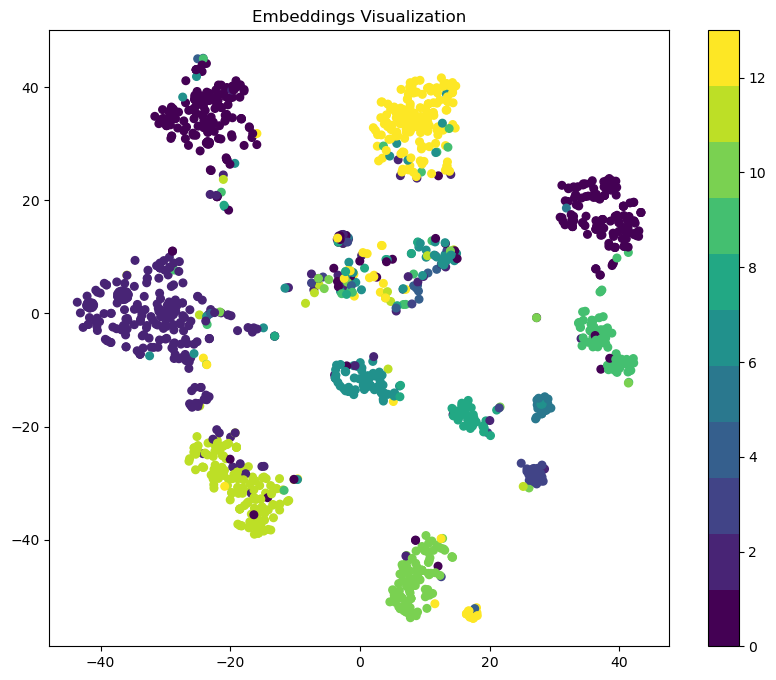

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap=plt.get_cmap('viridis', 11), s=30)
plt.colorbar()
plt.title("Embeddings Visualization")
plt.show()